In [85]:
import sys
sys.path.insert(1, '/scratch/gpfs/ls1546/icl_experiments/')

In [86]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import embedding
import transformer
import dataset_utils
from tqdm.auto import tqdm

In [87]:
#load MNIST
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
test_data = datasets.MNIST('../data', train=False,
                    transform=transform)

In [88]:
#augment MNIST with multiple tasks
n_tasks = 4
# task_gen = dataset_utils.RandomTasks(train_data, num_tasks=n_tasks)

# these will be the num of seeds we send into get_transformed_batch

In [89]:
batch_size = 32
lr = 3e-4
momentum = 0.9
steps = 2000
seq_len = 50 #this is what we previously called "batch_size"
trainloader = torch.utils.data.DataLoader(train_data, batch_size=seq_len, shuffle=True)
total_steps = int(np.ceil(steps/len(trainloader)))*len(trainloader)
log_freq = 100
device = 'cuda'
total_steps

2400

In [80]:
#instantiate model
model = transformer.ImageICLTransformer(d_model=64,device='cuda',block_size=100)
print(model)

using flash attention
Embedding Transformer with 816332 parameters, 210360 parameters in embedder & 604682 parameters in transformer


In [81]:
#train the model to do MNIST classification

model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50])

loss_history = [0]*total_steps
model.train()
data_avg_t = 0
loss_avg_t = 0

# here, our "batch_size" is actually the sequence length since we want to draw seq_length samples from the dataset, and then transform them batch_num times, where each transformation is a different task
# the batch should have shape: (batch_size,seq_len,1,28,28),
# right now it has shape: (seq_len,1,28,28), and we will add in the batch dimension in the loop below
step = 0
task_list = []
for epoch in tqdm(range(int(np.ceil(total_steps/len(trainloader))))):
    for images, labels in tqdm(trainloader):
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        start.record()
        # images, labels = task_gen.get_batch(batch_size,seq_len=seq_len,device=device)
        
        # add batch dimension
        images = torch.unsqueeze(images, 0).to(device)
        labels = torch.unsqueeze(labels, 0).to(device)
        # transform a batch, using a randomly selected task num from our list of n_tasks for each sequence in the batch, concatenated along the batch dimension
        for i in range(batch_size):
            if i == 0:
                temp_images, temp_labels, curr_seed = dataset_utils.get_transformed_batch(images, labels, seed=np.random.randint(n_tasks))
            else:
                temp2_images, temp2_labels, curr_seed = dataset_utils.get_transformed_batch(images, labels, seed=np.random.randint(n_tasks))
                temp_images = torch.cat((temp_images, temp2_images), 0)
                temp_labels = torch.cat((temp_labels, temp2_labels), 0)
            task_list.append(curr_seed)
        end.record()
        torch.cuda.synchronize()
        data_avg_t += start.elapsed_time(end)
        images = temp_images
        labels = temp_labels
        del temp_images, temp_labels, temp2_images, temp2_labels

        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)

        start.record()
        optimizer.zero_grad()
        outputs = model((images,labels))
        pred = outputs[:,-1,:]
        loss = criterion(pred,labels[:,-1])
        loss.backward()
        optimizer.step()
        end.record()
        torch.cuda.synchronize()
        loss_avg_t += start.elapsed_time(end)
        loss_history[step] = loss.item()
        step += 1

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]


DATA:  107.71286429405212
LOSS:  221.5931656519572


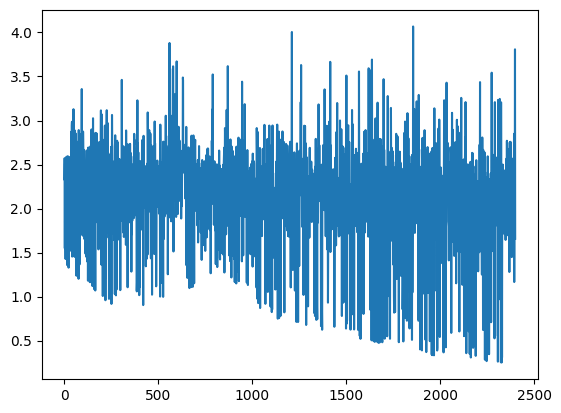

In [82]:
loss_history = np.array(loss_history)[:step]
plt.plot(loss_history)
print("\nDATA: ", data_avg_t/total_steps)
print("LOSS: ", loss_avg_t/total_steps)

In [83]:
def test_model(model, test_data, n_tasks, batch_size=32, seq_len=50, device='cuda'):
    correct = 0
    model.eval()
    
    test_task_list = []
    testloader = torch.utils.data.DataLoader(test_data, batch_size=seq_len, shuffle=False)
    num_batch = len(testloader)

    for images, labels in tqdm(testloader):
        # add batch dimension
        images = torch.unsqueeze(images, 0).to(device)
        labels = torch.unsqueeze(labels, 0).to(device)
        for batch in range(batch_size):
            if batch == 0:
                temp_images, temp_labels, curr_seed = dataset_utils.get_transformed_batch(images, labels, seed=np.random.randint(n_tasks))
            else:
                temp2_images, temp2_labels, curr_seed = dataset_utils.get_transformed_batch(images, labels, seed=np.random.randint(n_tasks))
                temp_images = torch.cat((temp_images, temp2_images), 0)
                temp_labels = torch.cat((temp_labels, temp2_labels), 0)
            test_task_list.append(curr_seed)

        images = temp_images
        labels = temp_labels
        del temp_images, temp_labels, temp2_images, temp2_labels

        outputs = model((images,labels))
        pred = outputs[:,-1,:]
        loss = criterion(pred,labels[:,-1])
        _, predicted = torch.max(pred, 1)
        correct += (predicted == labels[:,-1]).sum()
    accuracy = 100 * (correct.item()) / (batch_size*num_batch)
    print(correct.item())
    print(accuracy)

In [84]:
test_model(model, test_data, n_tasks, batch_size=32, seq_len=seq_len, device='cuda')

  0%|          | 0/200 [00:00<?, ?it/s]

1104
17.25
